In [1]:
#Import Library
from skimage.feature import graycomatrix, graycoprops
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import time
import pyfeats

c:\Users\320236468\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


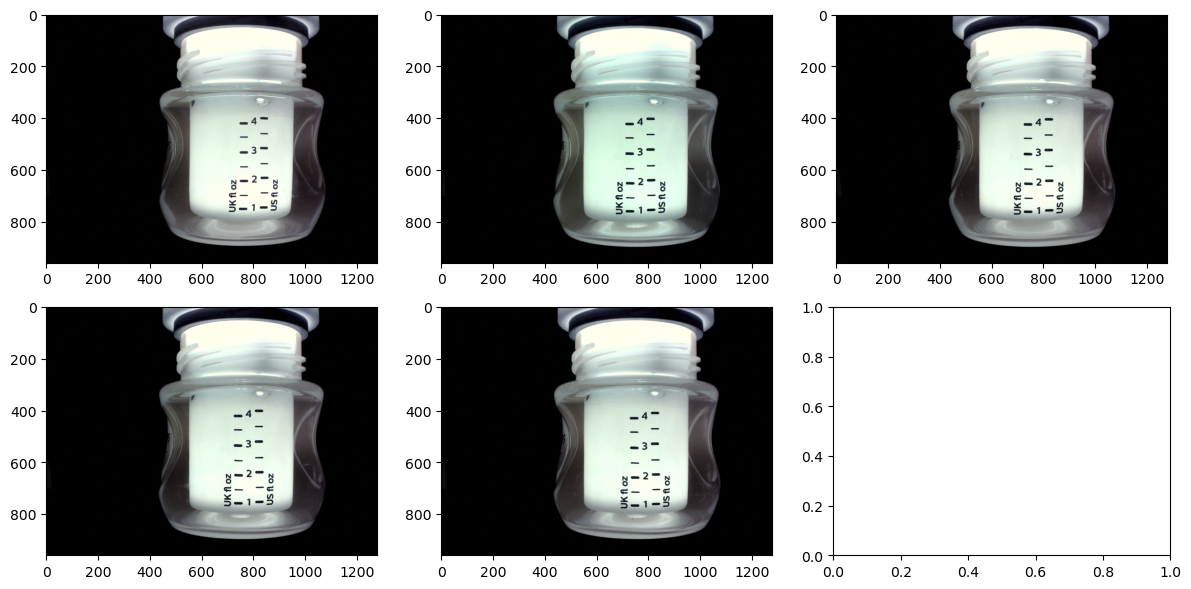

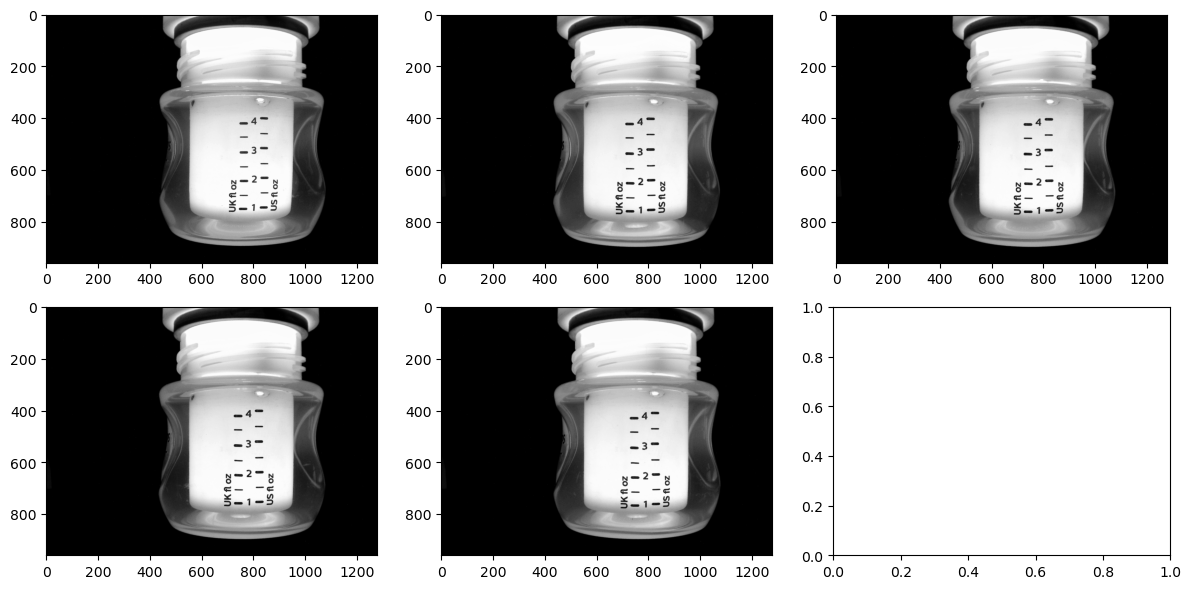

In [ ]:
good_sample = cv2.imread('CAMERA 4_OZ/good/Reject20230722202003044320.jpg')
colortoneSample1 = cv2.imread('CAMERA 4_OZ/color tone/Reject20230724142502040806.jpg')
colortoneSample2 = cv2.imread('CAMERA 4_OZ/color tone/Reject20230722151542456147.jpg')
colortoneSample3 = cv2.imread('CAMERA 4_OZ/color tone/Reject20230722151657134181.jpg')
colortoneSample4 = cv2.imread('CAMERA 4_OZ/color tone/Reject20230722151749452856.jpg')

gray_good_sample = cv2.cvtColor(good_sample, cv2.COLOR_BGR2GRAY)
gray_colortone1 = cv2.cvtColor(colortoneSample1, cv2.COLOR_BGR2GRAY)
gray_colortone2 = cv2.cvtColor(colortoneSample2, cv2.COLOR_BGR2GRAY)
gray_colortone3 = cv2.cvtColor(colortoneSample3, cv2.COLOR_BGR2GRAY)
gray_colortone4 = cv2.cvtColor(colortoneSample4, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(2, 3, figsize=(12,6))
fig.tight_layout()

ax[0, 0].imshow(good_sample)
ax[0, 1].imshow(colortoneSample1)
ax[0, 2].imshow(colortoneSample2)
ax[1, 0].imshow(colortoneSample3)
ax[1, 1].imshow(colortoneSample4)

fig, ax = plt.subplots(2, 3, figsize=(12,6))
fig.tight_layout()

ax[0, 0].imshow(gray_good_sample, cmap='gray')
ax[0, 1].imshow(gray_colortone1, cmap='gray')
ax[0, 2].imshow(gray_colortone2, cmap='gray')
ax[1, 0].imshow(gray_colortone3, cmap='gray')
ax[1, 1].imshow(gray_colortone4, cmap='gray')

In [13]:
def TemplateMatching(img, template):
    if len(img.shape) == 3:  # Color image
        imgGGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif len(img.shape) == 2:  # Grayscale image
        imgGGray = img
 
    templateMatch = cv2.imread(template, cv2.IMREAD_GRAYSCALE)

    w, h = templateMatch.shape[::-1]
    res = cv2.matchTemplate(imgGGray, templateMatch, cv2.TM_CCOEFF_NORMED ) 

    threshold = 0.8
    
    loc = np.where(res >= threshold)

    ij = np.unravel_index(np.argmax(res), res.shape)
    x, y = ij[::-1]
    max_corr = np.min(res)

    imgGoodCrop = img[y: y + h, x:x+w, :]
    
    return imgGoodCrop

def PyfeatsHistFeatures(img, range):
    a, b = range
    H, labels = pyfeats.histogram(img, img, bins=256)
    histogram = H[a:b]
    
    return histogram

def HuMomentFeatures(img):
    if len(img.shape) == 3:  # Color image
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif len(img.shape) == 2:  # Grayscale image
        gray_image = img
        
    pyfeatsHu = []
    hu_labels = []
    features, labels = pyfeats.hu_moments(gray_image)
    pyfeatsHu = np.append(features, pyfeatsHu)
    hu_labels = np.append(hu_labels, labels)
    
    return pyfeatsHu, hu_labels

def scikitGLCMFeatures(img):
    if len(img.shape) == 3:  # Color image
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif len(img.shape) == 2:  # Grayscale image
        gray_image = img

    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    

    # Compute the GLCM
    glcm = graycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Extract specific features from GLCM
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')
    
    glcm_analysis = [contrast, dissimilarity, homogeneity, energy, correlation]

    return glcm_analysis, angles

def calculate_histogram(img):
    image = img.flatten()
    
    hist, _ = np.histogram(image, bins=256, range=[0,255])
    return hist
    
def StatFeatures(img):
    mean = np.mean(PyfeatsHistFeatures(img, range=(0, 255)))
    variance = np.var(PyfeatsHistFeatures(img, range=(0, 255)))
    skewness = np.mean((PyfeatsHistFeatures(img, range=(0, 255)) - mean) ** 3)
    kurtosis = np.mean((PyfeatsHistFeatures(img, range=(0, 255)) - mean) ** 4)
    energy = np.sum(img ** 2)
    contrast = np.sum((np.arange(len(PyfeatsHistFeatures(img, range=(0, 255)))) - mean) ** 2 * PyfeatsHistFeatures(img, range=(0, 255)))
    Max = np.argmax(PyfeatsHistFeatures(img, range=(0, 255)))
    peak = PyfeatsHistFeatures(img, range=(0, 255))[Max]
    
    statFeatures = [mean, variance, skewness, kurtosis, energy, contrast, Max, peak]
    properties = ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Energy', 'Contrast', 'Max', 'Peak']
    
    return statFeatures, properties

def GLCMAnalysis(imgGood, colortone1, colortone2, colortone3, colortone4):
    goodGLCM, angels = scikitGLCMFeatures(imgGood)
    colortone1GLCM, _ = scikitGLCMFeatures(colortone1)
    colortone2GLCM, _ = scikitGLCMFeatures(colortone2)
    colortone3GLCM, _ = scikitGLCMFeatures(colortone3)
    colortone4GLCM, _ = scikitGLCMFeatures(colortone4)
    
    labels = ['Contrast', 'Entropy', 'Homogeneity', 'Energy', 'Correlation']

    fig, axs = plt.subplots(1, 5, figsize=(25, 5))

    for i, property_name in enumerate(labels):
        property_values1 = goodGLCM[i].flatten() 
        property_values2 = colortone1GLCM[i].flatten()
        property_values3 = colortone2GLCM[i].flatten() 
        property_values4 = colortone3GLCM[i].flatten()
        property_values5 = colortone4GLCM[i].flatten()   
        legend = [property_values1,property_values2,property_values3,property_values4,property_values5]
        
        axs[i].plot(angels, property_values1, marker='o', linestyle='-', label='Good', color='green')
        axs[i].plot(angels, property_values2, marker='o', linestyle='-', label='P1', color='red')
        axs[i].plot(angels, property_values3, marker='o', linestyle='-', label='P2', color='blue')
        axs[i].plot(angels, property_values4, marker='o', linestyle='-', label='P3', color='purple')
        axs[i].plot(angels, property_values5, marker='o', linestyle='-', label='P3', color='yellow')
        axs[i].set_title(property_name)
        axs[i].set_xlabel('Angle ')
        axs[i].set_ylabel(property_name)
        axs[i].grid(True)
        legend = axs[i].legend(legend, loc='best',bbox_to_anchor=(1.05, -0.1))
    plt.suptitle('GLCM Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()

def AllHistAnalysis(imgGood, colortone1, colortone2, colortone3, colortone4, range):
    histogram = np.arange(256)
    
    goodHist = PyfeatsHistFeatures(imgGood, range)
    colortone1Hist = PyfeatsHistFeatures(colortone1, range)
    colortone2Hist = PyfeatsHistFeatures(colortone2, range)
    colortone3Hist = PyfeatsHistFeatures(colortone3, range)
    colortone4Hist = PyfeatsHistFeatures(colortone4, range)
    
    plt.plot(histogram, goodHist, linestyle='-', label='Good', color='green')
    plt.plot(histogram, colortone1Hist, linestyle='-', label='Colortone 1', color='blue')
    plt.plot(histogram, colortone2Hist, linestyle='-', label='Colortone 2', color='red')
    plt.plot(histogram, colortone3Hist, linestyle='-', label='Colortone 3', color='purple')
    plt.plot(histogram, colortone4Hist, linestyle='-', label='Colortone 4', color='yellow')
    
    plt.xlabel('Histogram')
    plt.ylabel('Frekuensi')
    plt.title('Analisa Histogram Pyfeats')
    plt.legend()

    plt.show()

def AllStatAnalysis(imgGood, colortone1, colortone2, colortone3, colortone4):
    goodStat, properties = StatFeatures(imgGood)
    colortone1Stat, _ = StatFeatures(colortone1)
    colortone2Stat, _ = StatFeatures(colortone2)
    colortone3Stat, _ = StatFeatures(colortone3)
    colortone4Stat, _ = StatFeatures(colortone4)
    
    fig, axs = plt.subplots(1, 10, figsize=(25, 5))

    for i, property_name in enumerate(properties):
        property_values1 = goodStat[i].flatten()
        property_values2 = colortone1Stat[i].flatten()
        property_values3 = colortone2Stat[i].flatten()
        property_values4 = colortone3Stat[i].flatten()
        property_values5 = colortone4Stat[i].flatten()    
        legend = [property_values1,property_values2,property_values3,property_values4,property_values5]

        axs[i].bar(['Good'], property_values1, color='green')
        axs[i].bar(['Colortone 1'], property_values2, color='red')
        axs[i].bar(['Colortone 2'], property_values2, color='blue')
        axs[i].bar(['Colortone 3'], property_values3, color='purple')
        axs[i].bar(['Colortone 4'], property_values4, color='yellow')
        axs[i].set_title(property_name)
        axs[i].set_ylabel(property_name)
        legend = axs[i].legend(legend, loc='best',bbox_to_anchor=(0.9, -0.1))
    plt.suptitle('Statistical Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()

def AllHuAnalysis(imgGood, colortone1, colortone2, colortone3, colortone4):
    hu = np.arange(7)
    
    goodHu, labels = HuMomentFeatures(imgGood)
    colortone1Hu, _ = HuMomentFeatures(colortone1)
    colortone2Hu, _ = HuMomentFeatures(colortone2)
    colortone3Hu, _ = HuMomentFeatures(colortone3)
    colortone4Hu, _ = HuMomentFeatures(colortone4)
    
    bar_width = 0.2  # Adjust the bar width to leave space between groups
    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, _)) = plt.subplots(2, 4, figsize=(12, 8))

    for i in range(7):
        ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7][i]

        # Adjust bar positions to separate groups
        ax.bar(np.arange(1) - bar_width, goodHu[i], width=bar_width, label='Good', color='green')
        ax.bar(np.arange(1), colortone1Hu[i], width=bar_width, label='Colortone 1', color='blue')
        ax.bar(np.arange(1) + bar_width, colortone2Hu[i], width=bar_width, label='Colortone 2', color='red')
        ax.bar(np.arange(1) + 2 * bar_width, colortone3Hu[i], width=bar_width, label='Colortone 3', color='purple')
        ax.bar(np.arange(1) + 3 * bar_width, colortone4Hu[i], width=bar_width, label='Colortone 4', color='yellow')

        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlabel(f'{labels[i]}')
        ax.set_ylabel('Values')
        ax.legend()

    plt.tight_layout()
    plt.show()
    
    plt.plot(goodHu, label='Good', color='green')
    plt.plot(colortone1Hu, label='Missprint 1', color='blue')
    plt.plot(colortone2Hu, label='Missprint 2', color='red')
    plt.plot(colortone3Hu, label='Missprint 3', color='purple')
    plt.plot(colortone4Hu, label='Missprint 4', color='yellow')
    
    plt.title("Hu Moment Analysis")
    plt.legend()
    plt.show()
    
def plotImg(img1, img2, img3, img4, img5):
    fig, ax = plt.subplots(2, 3, figsize=(12,6))
    fig.tight_layout()

    ax[0, 0].imshow(img1)
    ax[0, 1].imshow(img2)
    ax[0, 2].imshow(img3)
    ax[1, 0].imshow(img4)
    ax[1, 1].imshow(img5)
    
def ImageBrightened(img):
    brightness_factor = 1.5  # You can adjust this value to control brightness
    
    brightened_image = cv2.convertScaleAbs(img, alpha=brightness_factor, beta=0.5)
    
    return brightened_image

def ContrastedImage(img):
    contrast_factor = 1.1  # You can adjust this value to control contrast
    
    contrasted_image = np.clip(contrast_factor * img, 0, 255).astype(np.uint8)
    
    return contrasted_image

In [5]:
def CropROI(image, position1, position2):
    imageSource = image
    x1, y1 = position1
    x2, y2 = position2
    
    crop_region = [[x1, y1], [x2, y2]]
    CroppedImage = imageSource[crop_region[0][1]:crop_region[1][1], crop_region[0][0]:crop_region[1][0]]
    
    return CroppedImage

def save_image (input_path, output_path):
    img = input_path
    cv2.imwrite(output_path, img)

In [6]:
def Thresholding(img):
    image_gray = img
    threshold_value = 80
    image_gray[image_gray > threshold_value] = 255
    
    #image_gray[image_gray < threshold_value] = 0
    
    return image_gray

In [20]:
template = CropROI(good_sample, (555, 350), (945, 780))
save_image (template, output_path = '../OZ overprint study/overprint_bottle_png/OZ_white bg_template.jpg')

# Crop Image and save

Fullprint

In [ ]:
directory = "CAMERA 4_OZ/good/"
i = 1

for path in os.listdir(directory):
    # check if current path is a file
    if os.path.isfile(os.path.join(directory, path)):
        nameFile = os.path.join(directory, path)
        image = cv2.imread(nameFile)
        
        Cropped = TemplateMatching(image, template='template/OZ_fullprint.jpg')
        thresholded = Thresholding(Cropped)
        output_path = f'CAMERA 4_OZ/good_cropped_png/OZ_Cropped{i}.png'
                  
    save_file = save_image(thresholded, output_path)

    i = i + 1

In [ ]:
directory = "CAMERA 4_OZ/color tone/"
i = 1

for path in os.listdir(directory):
    # check if current path is a file
    if os.path.isfile(os.path.join(directory, path)):
        nameFile = os.path.join(directory, path)
        image = cv2.imread(nameFile)
        
        Cropped = TemplateMatching(image, template='template/OZ_fullprint.jpg')
        thresholded = Thresholding(Cropped)
        output_path = f'CAMERA 4_OZ/color tone_cropped_png/OZ_Cropped{i}.png'
                  
    save_file = save_image(thresholded, output_path)

    i = i + 1

Full Image

In [ ]:
directory = "CAMERA 4_OZ/good/"
i = 1

for path in os.listdir(directory):
    # check if current path is a file
    if os.path.isfile(os.path.join(directory, path)):
        nameFile = os.path.join(directory, path)
        image = cv2.imread(nameFile)
        
        # Cropped = TemplateMatching(image, template='template/OZ_fullprint.jpg')
        thresholded = Thresholding(image)
        output_path = f'CAMERA 4_OZ/good_image_png/OZ_good_image{i}.png'
                  
    save_file = save_image(thresholded, output_path)

    i = i + 1

In [ ]:
directory = "CAMERA 4_OZ/color tone/"
i = 1

for path in os.listdir(directory):
    # check if current path is a file
    if os.path.isfile(os.path.join(directory, path)):
        nameFile = os.path.join(directory, path)
        image = cv2.imread(nameFile)
        
        # Cropped = TemplateMatching(image, template='template/OZ_fullprint.jpg')
        thresholded = Thresholding(image)
        output_path = f'CAMERA 4_OZ/color tone_image_png/OZ_color tone_image{i}.png'
                  
    save_file = save_image(thresholded, output_path)

    i = i + 1

Bottle ROI

In [ ]:
directory = "CAMERA 4_OZ/good/"
i = 1

for path in os.listdir(directory):
    # check if current path is a file
    if os.path.isfile(os.path.join(directory, path)):
        nameFile = os.path.join(directory, path)
        image = cv2.imread(nameFile)
        
        Cropped = TemplateMatching(image, template='template/OZ_bottle.jpg')
        thresholded = Thresholding(Cropped)
        output_path = f'CAMERA 4_OZ/good_bottle_png/OZ_good_bottle{i}.png'
                  
    save_file = save_image(thresholded, output_path)

    i = i + 1

In [ ]:
directory = "CAMERA 4_OZ/color tone/"
i = 1

for path in os.listdir(directory):
    # check if current path is a file
    if os.path.isfile(os.path.join(directory, path)):
        nameFile = os.path.join(directory, path)
        image = cv2.imread(nameFile)
        
        Cropped = TemplateMatching(image, template='template/OZ_bottle.jpg')
        thresholded = Thresholding(Cropped)
        output_path = f'CAMERA 4_OZ/color tone_bottle_png/OZ_color tone_bottle{i}.png'
                  
    save_file = save_image(thresholded, output_path)

    i = i + 1

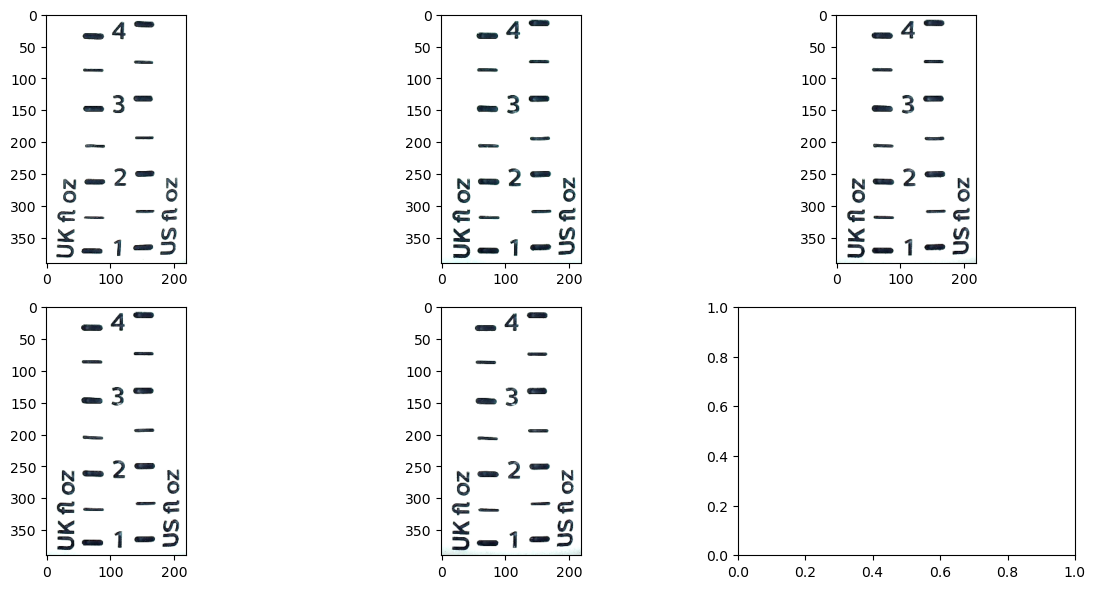

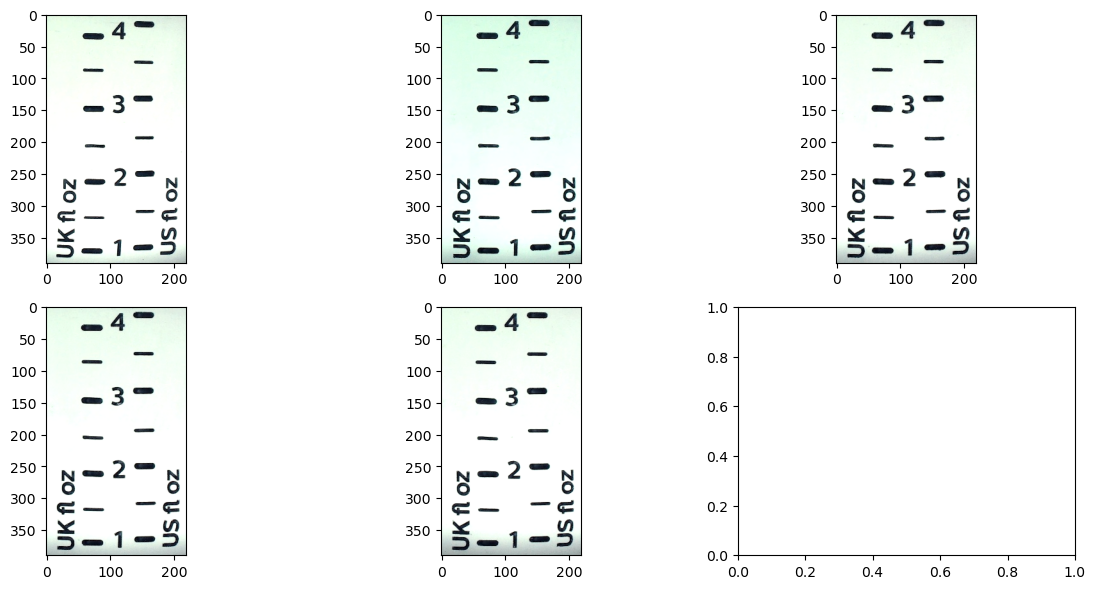

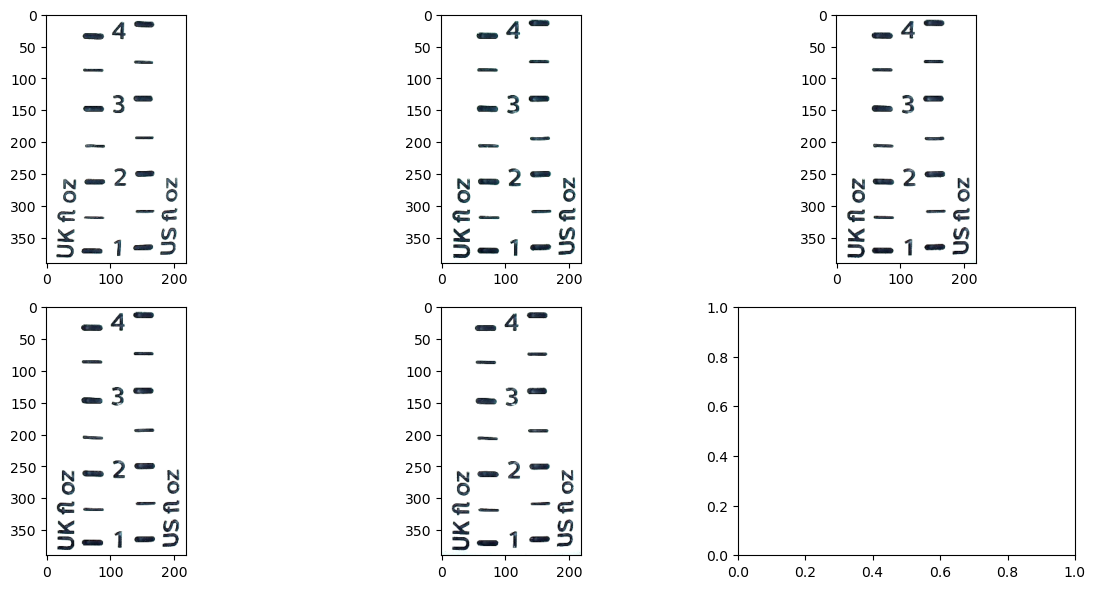

In [ ]:
plotImg1 = plotImg(ImageBrightened(TemplateMatching(good_sample, template='template/OZ_fullprint.jpg')),
                   ImageBrightened(TemplateMatching(colortoneSample1, template='template/OZ_fullprint.jpg')),
                   ImageBrightened(TemplateMatching(colortoneSample2, template='template/OZ_fullprint.jpg')),
                   ImageBrightened(TemplateMatching(colortoneSample3, template='template/OZ_fullprint.jpg')),
                   ImageBrightened(TemplateMatching(colortoneSample4,template='template/OZ_fullprint.jpg')))

plotImg2 = plotImg(ContrastedImage(TemplateMatching(good_sample, template='template/OZ_fullprint.jpg')),
                   ContrastedImage(TemplateMatching(colortoneSample1, template='template/OZ_fullprint.jpg')),
                   ContrastedImage(TemplateMatching(colortoneSample2, template='template/OZ_fullprint.jpg')),
                   ContrastedImage(TemplateMatching(colortoneSample3, template='template/OZ_fullprint.jpg')),
                   ContrastedImage(TemplateMatching(colortoneSample4,template='template/OZ_fullprint.jpg')))

plotImg3 = plotImg(ContrastedImage(ImageBrightened(TemplateMatching(good_sample, template='template/OZ_fullprint.jpg'))),
                   ContrastedImage(ImageBrightened(TemplateMatching(colortoneSample1, template='template/OZ_fullprint.jpg'))),
                   ContrastedImage(ImageBrightened(TemplateMatching(colortoneSample2, template='template/OZ_fullprint.jpg'))),
                   ContrastedImage(ImageBrightened(TemplateMatching(colortoneSample3, template='template/OZ_fullprint.jpg'))),
                   ContrastedImage(ImageBrightened(TemplateMatching(colortoneSample4,template='template/OZ_fullprint.jpg'))))